## Exercise 9: Geometry Constrained Feature Matching


In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

### The Eight Point Algorithm

Here you will write a function that uses the eight point algorithm for fundamental matrix estimation. This should be a slight modification of your algorithm for homography estimation. As for the homography estimation the data points should also be normalized.
Find the fundamental matrix that you computed for the images in `TwoImageData.npy` in week 3 and denote it `Ftrue`.


In [2]:
data= np.load('TwoImageData.npy', allow_pickle=True).item()
qs= np.load('qs.npy', allow_pickle=True).item()

In [3]:
def CrossOp(p):
    x,y,z=p[0],p[1],p[2]
    cross=np.array([[0,-z,y],[z, 0,-x],[-y,x,0]])
    return cross

def compute_Fmat_Emat(t,R,K1,K2):
    #K1, K2 instrincisc properties of each camera. 
    t_cross=CrossOp(t[:,0])
    E=t_cross@R #essential matrix
    F=np.linalg.inv(K2).T@E@np.linalg.inv(K1)
    return E, F

In [4]:
t1=data['t1']
t2=data['t2']
R2=data['R2']
R1=data['R1']
K=data['K']
Etrue,Ftrue= compute_Fmat_Emat(t2,R2,K,K)
print('The fundamental matrix is F =')
print(Ftrue)

The fundamental matrix is F =
[[ 6.67972386e-12 -7.85049967e-10  1.17921973e-07]
 [-9.75936980e-10 -4.86806510e-12  3.28699196e-05]
 [ 4.23506610e-07 -3.21704080e-05 -2.12002228e-04]]


- **Exercise 9.1**. Implement a function `Fest_8point` that estimates a fundamental matrix from eight or more point correspondences, using the linear algorithm.
Use the points in `qs.np` to estimate a fundamental matrix, and check that your estimated fundamental matrix is identical to `Ftrue` up to scale and numerical error.




In [5]:
q1=qs['q1'] #3x8 points
q2=qs['q2'] #3x8 points

In [6]:
def Fest_8point(q1,q2):
    B=np.zeros((1,9))
    for i in range(q1.shape[1]):
        x1i=q1[0][i]
        y1i=q1[1][i]
        x2i=q2[0][i]
        y2i=q2[1][i]
        
        B_i=np.array([[x1i*x2i,x1i*y2i,x1i,y1i*x2i,y1i*y2i,y1i,x2i,y2i,1]])
        B=np.vstack([B, B_i])

    B=B[1:,:] 
    u,s,vh= np.linalg.svd(B,full_matrices=True, compute_uv=True)
    
    #The parameters are in the last line of Vh and normalize them:
    P = vh[-1,:] / vh[-1,-1] 
    F_esti=P.reshape((3,3),order='F')

    return F_esti

In [7]:
F_esti=Fest_8point(q1,q2)

print('The true fundamental matrix is F =')
print(Ftrue)
print('\n')
print('The estimated fundamental matrix is F =')
print(F_esti)

#Scale and numerical error:
scale=Ftrue/F_esti
print('\n')

s=scale[0,0]
print('Scale of the estiamted F vs. truth::',s)
print('Numerical error:')
print(Ftrue-s*F_esti)

The true fundamental matrix is F =
[[ 6.67972386e-12 -7.85049967e-10  1.17921973e-07]
 [-9.75936980e-10 -4.86806510e-12  3.28699196e-05]
 [ 4.23506610e-07 -3.21704080e-05 -2.12002228e-04]]


The estimated fundamental matrix is F =
[[-3.15078002e-08  3.70302696e-06 -5.56229877e-04]
 [ 4.60342794e-06  2.29623299e-08 -1.55045161e-01]
 [-1.99765169e-03  1.51745612e-01  1.00000000e+00]]


Scale of the estiamted F vs. truth:: -0.0002120022283096701
Numerical error:
[[ 0.00000000e+00  8.54754678e-20 -1.68653127e-17]
 [ 8.48726600e-20  3.44452063e-22 -3.12343738e-15]
 [-3.62243169e-17  3.05707066e-15  2.00960125e-14]]


### Feature Matching

- **Exercise 9.2**. Repeat part of the exercise from last week, by matching the two images from `TwoImageData.npy`. However, this time do not filter matches by the ratio test, only use cross checking as done by `cv2.BFMatcher_create(crossCheck=True)`.

    Visualize the result and confirm that it looks reasonable compared to your expectations.




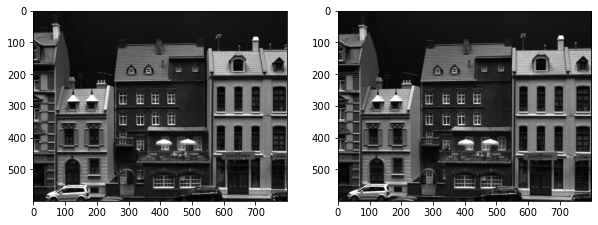

In [8]:
#images:
im1=data['im1']
im2=data['im2']

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,7))
ax1.imshow(im1,cmap='gray');
ax2.imshow(im2,cmap='gray');

In [9]:
# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(im1,None)
kp2, des2 = sift.detectAndCompute(im2,None)

# BFMatcher with default params
bf = cv2.BFMatcher(crossCheck=True)
matches = bf.match(des1,des2)
     
print('Number of matches:',len(matches))


Number of matches: 2086


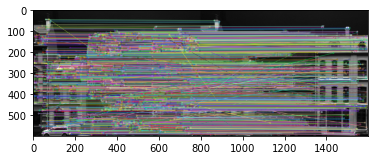

In [10]:
img3 = cv2.drawMatches(im1, kp1, im2, kp2,matches,None,flags=2)
plt.imshow(img3)
plt.show()

### Fundamental matrix estimation via RANSAC

Make a copy of your RANSAC algorithm that fits straight lines, and modify it to fit fundamental matrices instead.

- **Exercise 9.3**. Sample eight random matches. This can be done with the following code `np.random.choice(matches, 8, replace=False)`.

    Use your function `Fest_8point` to estimate the fundamental matrix from these eight matches. 
    
    Write a function `SampsonsDistance(F, p1, p2)` that computes Sampson’s distance.
    
    Set points to inliers if their Sampson’s distance is less than 3.84 · 3ˆ2 (**= 34.86**). Explain where this value comes from.

    Use your `Fest_8point` to estimate the final fundamental matrix using all inliers of the best model.
    
    Run your algorithm on the the images from `TwoImageData.npy`. Compare your estimated `F` to `Ftrue`. You could use the following code to compare them:
    
    `(F*Ftrue).sum() / (np.linalg.norm(F)*np.linalg.norm(Ftrue)).`

    Explain what this code does.

In [11]:
#Convert matches to points: 
list_p1=[]
list_p2=[]
for mat in matches:
    # Get the matching keypoints for each of the images
    img1_idx = mat.queryIdx
    img2_idx = mat.trainIdx

    # Get the coordinates
    (x1, y1) = kp1[img1_idx].pt
    (x2, y2) = kp2[img2_idx].pt

    # Append to each list
    list_p1.append((x1, y1))
    list_p2.append((x2, y2))

In [12]:
#Select 8 of n points (randomly)
def select_8points(matches):
    p1_sel=[]
    p2_sel=[]
    
    ran_mat=np.random.choice(matches, 8, replace=False)
    
    for sel in ran_mat:
        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # Get the coordinates
        (x1, y1) = kp1[img1_idx].pt
        (x2, y2) = kp2[img2_idx].pt

        # Append to each list
        p1_sel.append((x1, y1))
        p2_sel.append((x2, y2))
    
    return p1_sel,p2_sel

In [13]:
p1_sel,p2_sel=select_8points(matches)
    
q1m=np.array(p1_sel).T
q2m=np.array(p2_sel).T

F_esti_mat=Fest_8point(q1m,q2m)
print(F_esti_mat)

[[-2.38232150e-06  2.78064805e-05 -3.70895833e-04]
 [-2.39678437e-05  8.95333550e-06  3.62202622e-04]
 [ 6.31633519e-05 -9.31992787e-04  1.00000000e+00]]


In [14]:
#Compute SAMPSON'S DISTANCE BETWEEN POINTS:
def SampsonsDistance(F, q1, q2):
    
    one=np.ones(1)
    p1=np.reshape(np.concatenate([q1, one]),[3,1])
    p2=np.reshape(np.concatenate([q2, one]),[3,1])
    
    a=(p2.T@F_esti_mat@p1)**2
    b=p2.T@F_esti_mat
    c=F_esti_mat@p1

    b1=(b[0][0])**2
    b2=(b[0][1])**2
    c1=(c[0][0])**2
    c2=(c[1][0])**2
    sumall=b1+b2+c1+c2

    DSamp=a/sumall

    return DSamp


#Set points to inliers if their Sampson’s distance is less than 3.84 · 3ˆ2. 
def isinlier(F,q1,q2,thre):
    
    d=SampsonsDistance(F,q1,q2)
    
    isinlier= d<thre
    
    #The function returns True if the point is an inlier, or False if it is an outlier. 
    return isinlier


def n_inliers(list_p1,list_p2,F,thre):

    num_inliers=0
    inliers_points1=[]
    inliers_points2=[]
    
    for a in range(len(list_p1)):
        p1=np.array(list_p1[a])
        p2=np.array(list_p2[a])
        
        if (isinlier(F,p1,p2,thre) == True):
            num_inliers=num_inliers+1
            inliers_points1.append(p1)
            inliers_points2.append(p2)
        
    return num_inliers, inliers_points1,inliers_points2

In [15]:
#RANSAC ALGORITHM

def RANSAC_algorithm(N_iter,list_p1,list_p2,thre):
    
    for itera in range(N_iter):
        #We first select the 8 random points
        p1_sel,p2_sel=select_8points(matches) 
        q1m=np.array(p1_sel).T
        q2m=np.array(p2_sel).T

        #Estimate F matrix from the selected 8 random 
        F_esti_mat=Fest_8point(q1m,q2m)

        num_inliers,inliers_points1,inliers_points2=n_inliers(list_p1,list_p2,F_esti_mat,thre)

        if itera==0:
                best_Festi=F_esti_mat
                max_num_inliers=num_inliers
                best_inliers1=inliers_points1
                best_inliers2=inliers_points2

        else:
            if num_inliers>max_num_inliers:
                max_num_inliers=num_inliers
                best_Festi=F_esti_mat
                best_inliers1=inliers_points1
                best_inliers2=inliers_points2

    return best_Festi,max_num_inliers,best_inliers1,best_inliers2


In [16]:
thre=3.84*(3**2)
best_Festi,max_num_inliers,best_inliers1,best_inliers2=RANSAC_algorithm(200,list_p1,list_p2,thre)

In [18]:
print('The maximum number of inliers are:',max_num_inliers)

The maximum number of inliers are: 83


In [19]:
def Fest_all_inliers(best_inliers1,best_inliers2):
    B=np.zeros((1,9))
    for i in range(len(best_inliers1)):
        x1i=best_inliers1[i][0]
        y1i=best_inliers1[i][1]
        x2i=best_inliers2[i][0]
        y2i=best_inliers2[i][1]
        
        B_i=np.array([[x1i*x2i,x1i*y2i,x1i,y1i*x2i,y1i*y2i,y1i,x2i,y2i,1]])
        B=np.vstack([B, B_i])

    B=B[1:,:] 
    u,s,vh= np.linalg.svd(B,full_matrices=True, compute_uv=True)
    
    #The parameters are in the last line of Vh and normalize them:
    P = vh[-1,:] / vh[-1,-1] 
    F_esti=P.reshape((3,3),order='F')

    return F_esti


In [20]:
F=Fest_all_inliers(best_inliers1,best_inliers2)
print('The estimated fundamental matrix from all inliers is:')
print(F)
print('\n')

comp=(F*Ftrue).sum() / (np.linalg.norm(F)*np.linalg.norm(Ftrue))
print('Comparison:',comp)


The estimated fundamental matrix from all inliers is:
[[ 2.38763472e-06 -4.86285015e-06 -1.15324458e-03]
 [ 1.57043664e-06  1.57032267e-06 -1.31563288e-03]
 [-1.92709664e-03  3.32163040e-03  1.00000000e+00]]


Comparison: -0.9779521363873517


- **Exercise 9.4**. Find the images you captured last week or capture new ones. Match SIFT features between these images using cross checking.

    Estimate the fundamental matrix between these images using your RANSAC algorithm. Comment on how well the fundamental matrix acts as a regularizer on which matches are used.

